### Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [2]:
cleaned_df = pd.read_csv('../data/cleaned/cleaned_df.csv')
cleaned_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [3]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406337 entries, 0 to 406336
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Invoice      406337 non-null  int64  
 1   StockCode    406337 non-null  object 
 2   Description  406337 non-null  object 
 3   Quantity     406337 non-null  int64  
 4   InvoiceDate  406337 non-null  object 
 5   Price        406337 non-null  float64
 6   Customer ID  406337 non-null  float64
 7   Country      406337 non-null  object 
dtypes: float64(2), int64(2), object(4)
memory usage: 24.8+ MB


In [ ]:
#converting the datatype of InvoiceDate to date
cleaned_df['InvoiceDate'] = pd.to_datetime(cleaned_df['InvoiceDate'])

In [ ]:
# calculating the TotalSales based on quantity and price

cleaned_df['TotalSales'] = cleaned_df['Quantity']*cleaned_df['Price']
cleaned_df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalSales
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


Aggregating the data based on Customer Id and calculating three features:
- MonetaryValue --> How much the customer has spent
- Frequency --> How often the customer has purchased
- Recency --> How recently the customer purchased (This feature is derived from the LastPurchase Date)

In [6]:
aggregated_df = cleaned_df.groupby(by='Customer ID',as_index=False).agg(
    MonetaryValue = ('TotalSales', 'sum'), 
    Frequency= ('Invoice','nunique'), 
    LastPurchase = ('InvoiceDate', 'max'))

aggregated_df.head()

,Customer ID,MonetaryValue,Frequency,LastPurchase
0,12346.0,169.36,2,2010-06-28 13:53:00
1,12347.0,1323.32,2,2010-12-07 14:57:00
2,12348.0,221.16,1,2010-09-27 14:59:00
3,12349.0,2221.14,2,2010-10-28 08:23:00
4,12351.0,300.93,1,2010-11-29 15:23:00


In [7]:
max_invoice_date = aggregated_df["LastPurchase"].max()

aggregated_df["Recency"] = (max_invoice_date - aggregated_df["LastPurchase"]).dt.days

aggregated_df.head(5)

,Customer ID,MonetaryValue,Frequency,LastPurchase,Recency
0,12346.0,169.36,2,2010-06-28 13:53:00,164
1,12347.0,1323.32,2,2010-12-07 14:57:00,2
2,12348.0,221.16,1,2010-09-27 14:59:00,73
3,12349.0,2221.14,2,2010-10-28 08:23:00,42
4,12351.0,300.93,1,2010-11-29 15:23:00,10


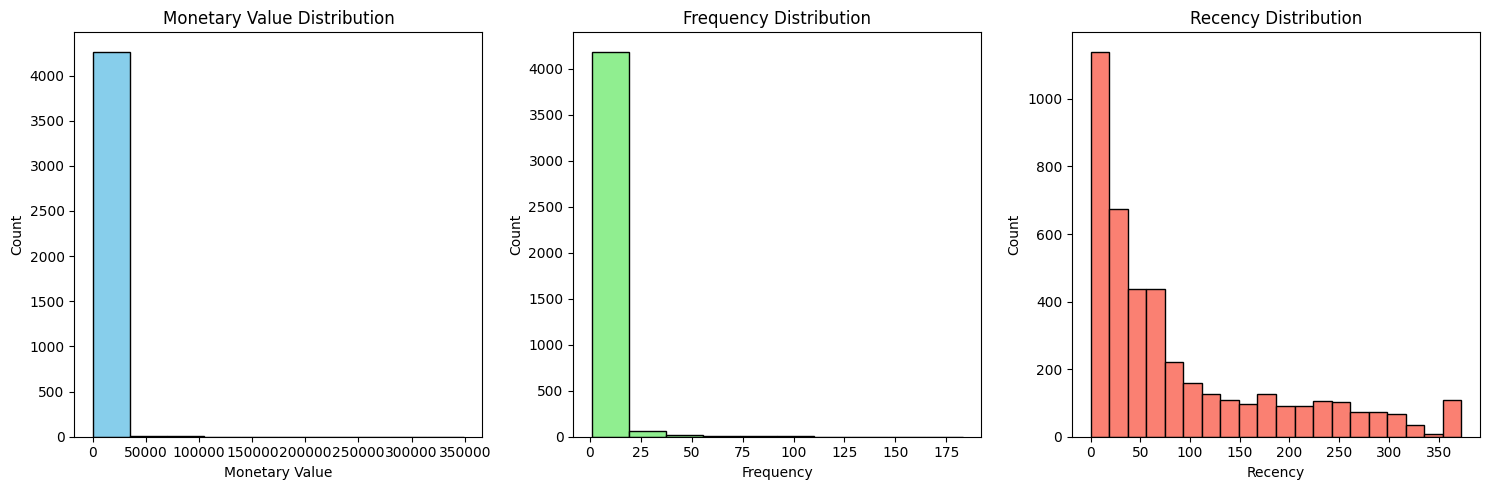

In [ ]:
# Checking the distribution of the created features for outliers
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(aggregated_df['MonetaryValue'], bins=10, color='skyblue', edgecolor='black')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
plt.hist(aggregated_df['Frequency'], bins=10, color='lightgreen', edgecolor='black')
plt.title('Frequency Distribution')
plt.xlabel('Frequency')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
plt.hist(aggregated_df['Recency'], bins=20, color='salmon', edgecolor='black')
plt.title('Recency Distribution')
plt.xlabel('Recency')
plt.ylabel('Count')

plt.tight_layout()
plt.show()


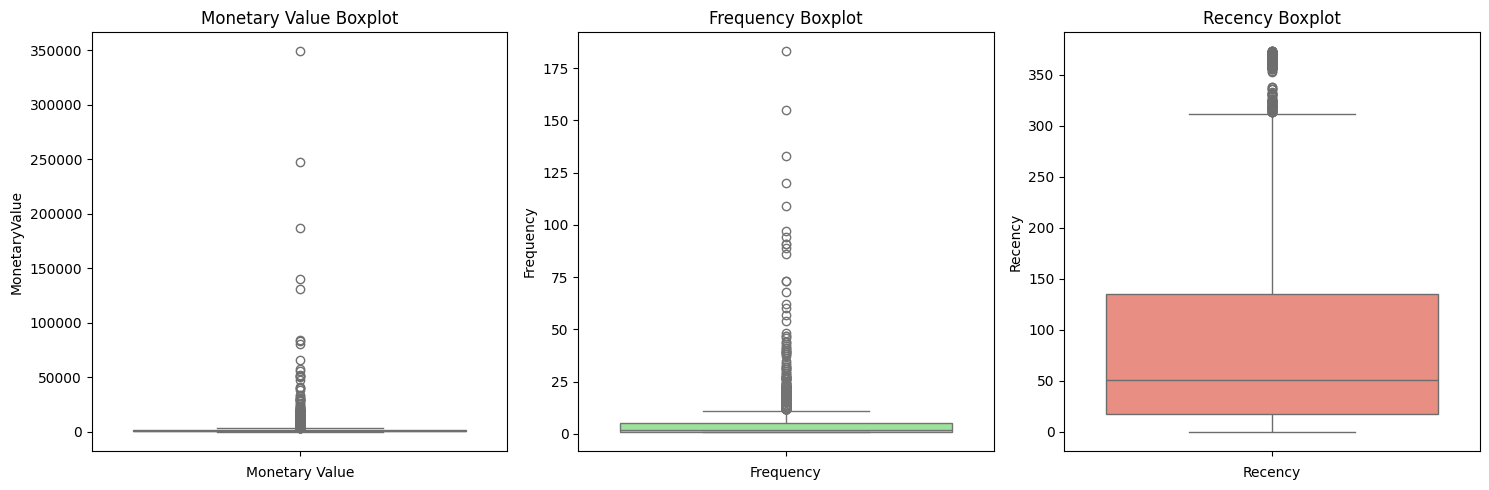

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=aggregated_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=aggregated_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=aggregated_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

As we can see there are significant number of outliers in MonetaryValue and Frequency feature based on the Box Plot

In [10]:
M_Q1 = aggregated_df['MonetaryValue'].quantile(0.25)
M_Q3 = aggregated_df['MonetaryValue'].quantile(0.75)

M_IQR = M_Q3 - M_Q1
upper_bound = M_Q3+1.5*M_IQR  
lower_bound = M_Q1-1.5*M_IQR  

monetary_outliers = aggregated_df[(aggregated_df['MonetaryValue'] > upper_bound) | (aggregated_df['MonetaryValue'] < lower_bound )]
monetary_outliers.describe()

,Customer ID,MonetaryValue,Frequency,LastPurchase,Recency
count,423.000000,423.000000,423.000000,423,423.000000
mean,15103.040189,12188.101740,17.167849,2010-11-09 12:26:02.978723328,30.035461
min,12357.000000,3802.040000,1.000000,2009-12-10 18:03:00,0.000000
25%,13622.000000,4605.940000,8.000000,2010-11-08 13:17:30,3.000000
50%,14961.000000,6191.320000,12.000000,2010-11-26 12:19:00,13.000000
75%,16692.000000,10273.235000,18.000000,2010-12-06 10:34:30,31.000000
max,18260.000000,349164.350000,183.000000,2010-12-09 19:32:00,364.000000
std,1728.661406,25830.851045,19.729755,NaN,51.541004


In [11]:
F_Q1 = aggregated_df['Frequency'].quantile(0.25)
F_Q3 = aggregated_df['Frequency'].quantile(0.75)

F_IQR = F_Q3 - F_Q1
upper_bound = F_Q3+1.5*F_IQR  
lower_bound = F_Q1-1.5*F_IQR  

frequency_outliers = aggregated_df[(aggregated_df['Frequency'] > upper_bound) | (aggregated_df['Frequency'] < lower_bound )]
frequency_outliers.describe()

,Customer ID,MonetaryValue,Frequency,LastPurchase,Recency
count,279.000000,279.000000,279.000000,279,279.000000
mean,15352.655914,14409.714932,23.810036,2010-11-23 11:06:20.645161216,16.089606
min,12437.000000,1094.390000,12.000000,2010-05-12 16:51:00,0.000000
25%,13800.000000,4331.560500,13.000000,2010-11-20 13:14:30,2.000000
50%,15465.000000,6615.770000,17.000000,2010-12-02 10:46:00,7.000000
75%,16828.500000,11692.405000,23.000000,2010-12-07 11:08:30,19.000000
max,18260.000000,349164.350000,183.000000,2010-12-09 19:32:00,211.000000
std,1748.429987,31381.736785,21.932937,NaN,26.589117


In [ ]:
# removing the outliers and filtering the data

filtered_df = aggregated_df[(~aggregated_df.index.isin(monetary_outliers.index)) & (~aggregated_df.index.isin(frequency_outliers.index))]
filtered_df.describe()


,Customer ID,MonetaryValue,Frequency,LastPurchase,Recency
count,3809.000000,3809.000000,3809.000000,3809,3809.000000
mean,15376.482804,885.502197,2.863481,2010-09-03 11:16:46.516146176,97.082174
min,12346.000000,1.550000,1.000000,2009-12-01 10:49:00,0.000000
25%,13912.000000,279.910000,1.000000,2010-07-08 14:48:00,22.000000
50%,15389.000000,588.050000,2.000000,2010-10-12 16:25:00,58.000000
75%,16854.000000,1269.050000,4.000000,2010-11-17 13:14:00,154.000000
max,18287.000000,3788.210000,11.000000,2010-12-09 20:01:00,373.000000
std,1693.199806,817.672283,2.243748,NaN,98.111495


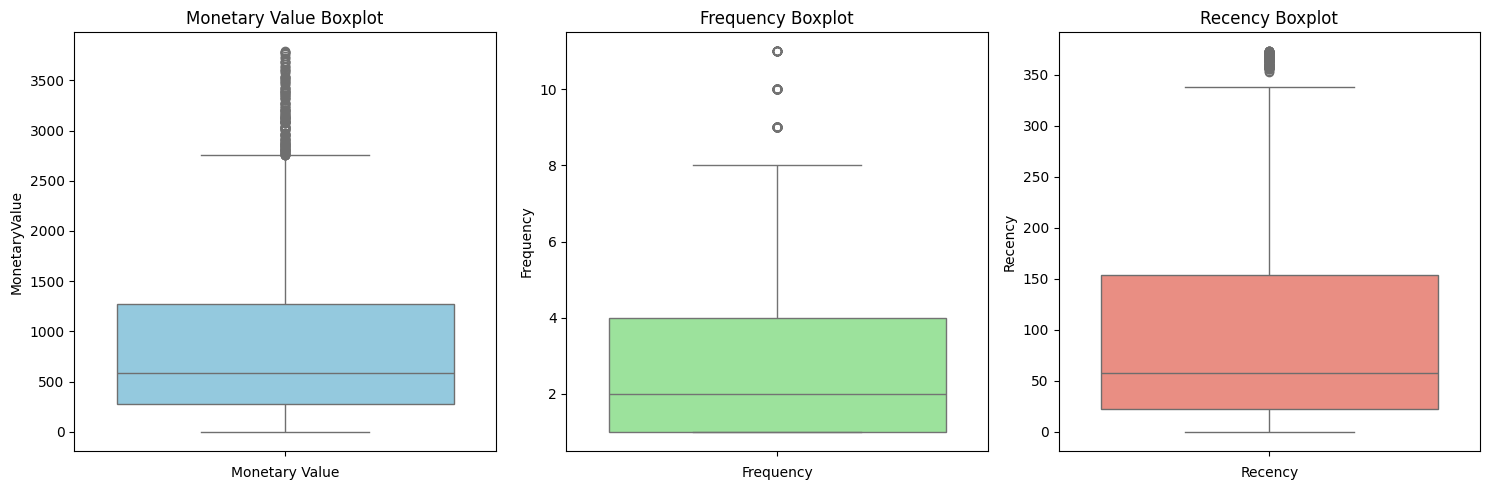

In [ ]:
# Checking the filtered data
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data=filtered_df['MonetaryValue'], color='skyblue')
plt.title('Monetary Value Boxplot')
plt.xlabel('Monetary Value')

plt.subplot(1, 3, 2)
sns.boxplot(data=filtered_df['Frequency'], color='lightgreen')
plt.title('Frequency Boxplot')
plt.xlabel('Frequency')

plt.subplot(1, 3, 3)
sns.boxplot(data=filtered_df['Recency'], color='salmon')
plt.title('Recency Boxplot')
plt.xlabel('Recency')

plt.tight_layout()
plt.show()

As we can see now the data is clearly visible and significant number of outliers are removed.

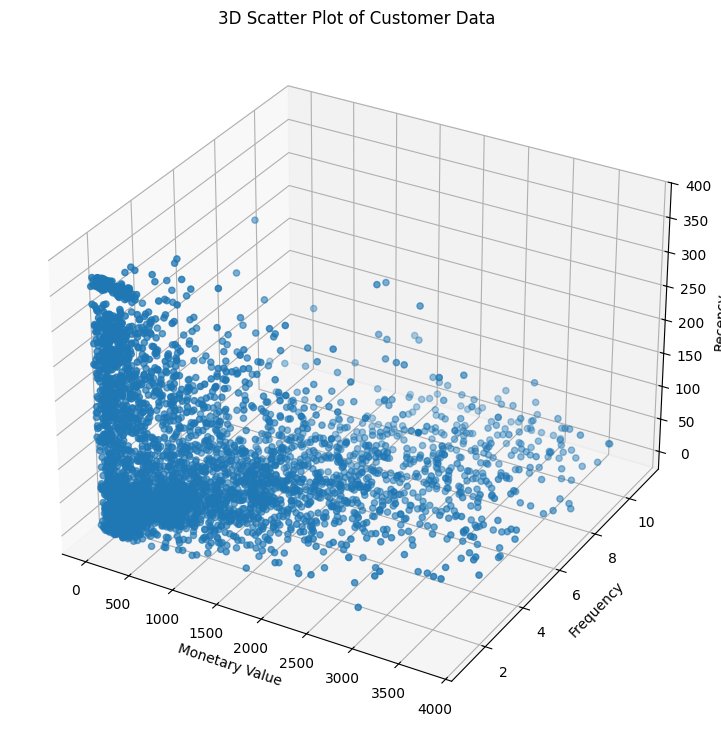

In [14]:
fig = plt.figure(figsize=(9,9))

ax = fig.add_subplot(projection="3d")

scatter = ax.scatter(filtered_df["MonetaryValue"], filtered_df["Frequency"], filtered_df["Recency"])

ax.set_xlabel('Monetary Value')
ax.set_ylabel('Frequency')
ax.set_zlabel('Recency')

ax.set_title('3D Scatter Plot of Customer Data')

plt.show()

As we can see the scale for all three features are different so making it to one scale using Standardization.

In [15]:
# feature scaling
sc = StandardScaler()
scaled_data = sc.fit_transform(filtered_df[['Frequency','MonetaryValue','Recency']])
scaled_data

array([[-0.38488934, -0.87594534,  0.68214853],
       [-0.38488934,  0.5355144 , -0.96925093],
       [-0.83063076, -0.81258645, -0.24548944],
       ...,
       [-0.83063076, -0.62197163,  2.01753946],
       [-0.38488934,  0.44146683,  0.14187587],
       [ 0.50659348,  1.72488781, -0.81634357]], shape=(3809, 3))

In [16]:
scaled_data_df = pd.DataFrame(scaled_data,index=filtered_df.index, columns=("MonetaryValue", "Frequency", "Recency"))
scaled_data_df.head()

,MonetaryValue,Frequency,Recency
0,-0.384889,-0.875945,0.682149
1,-0.384889,0.535514,-0.969251
2,-0.830631,-0.812586,-0.245489
3,-0.384889,1.633678,-0.561498
4,-0.830631,-0.715016,-0.887700


In [17]:
scaled_data_df.to_csv('../data/cleaned/scaled.csv', index=False)
filtered_df.to_csv('../data/cleaned/filtered_df.csv', index=False)